### Chapter 6: Applying RESNET Model to Detect Human Body Keypoints

In [1]:
# import modules
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as tt
from PIL import Image, ImageDraw, ImageFont
from torchvision import models

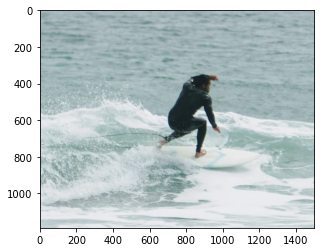

In [2]:
# load image to analyze
img = Image.open('./media/surfer.jpg')
plt.imshow(img);

In [3]:
# load a trained Keypoints R-CNN ResNet FPN model
kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [4]:
# create a transformation function that normalizes the input image
def normalize(img):
    normalize_t = tt.Compose([tt.Resize(256),
                              tt.CenterCrop(224),
                              tt.ToTensor(),
                              tt.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)

In [5]:
# apply the transformation function to the image
img_tensor = normalize(img)

In [6]:
# apply the model
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[ 94.7989,  52.3266, 164.8757, 160.1113]], grad_fn=<StackBackward>),
 'labels': tensor([1]),
 'scores': tensor([0.9396], grad_fn=<IndexBackward>),
 'keypoints': tensor([[[148.5430,  77.6630,   1.0000],
          [148.5430,  74.0235,   1.0000],
          [147.9846,  73.1836,   1.0000],
          [148.8222,  73.7435,   1.0000],
          [143.7968,  73.4636,   1.0000],
          [147.1471,  90.5412,   1.0000],
          [126.2078,  75.1433,   1.0000],
          [149.6598, 104.5392,   1.0000],
          [103.8726, 109.8584,   1.0000],
          [156.0812, 121.3368,   1.0000],
          [155.2436, 119.6570,   1.0000],
          [130.1165, 105.6590,   1.0000],
          [114.4818, 111.8181,   1.0000],
          [144.6344, 117.6973,   1.0000],
          [145.1927, 118.2572,   1.0000],
          [137.3754, 144.5735,   1.0000],
          [109.7356, 133.0951,   1.0000]]], grad_fn=<CopySlices>),
 'keypoints_scores': tensor([[ 4.8523,  5.4999,  6.5991,  0.6450,  5.7366, -0.1321,

In [7]:
# create a function that returns the keypoints
def get_keypoint_detections(img, threshold=0.7):
    with torch.no_grad():
        img_t = tt.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i, s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(), kpts[i].cpu().numpy()) for i in idxs]
    return res

In [8]:
# create a function that matches body part name with detection
def to_json(preds):
    names = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 
             'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 
             'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 
             'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
    detections = [k for (_, k) in preds]
    res = []
    for kpts in detections:
        d = {n: k.round().astype(int).tolist() for (n, k) in zip(names, kpts)}
        res.append(d)
    return json.dumps(res)

In [9]:
# apply the keypoints detection function
keypoint_detections = get_keypoint_detections(img)

In [10]:
# convert the keypoints to json
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [924, 426, 1], "left_eye": [924, 411, 1], "right_eye": [922, 410, 1], "left_ear": [887, 407, 1], "right_ear": [893, 410, 1], "left_shoulder": [801, 425, 1], "right_shoulder": [906, 475, 1], "left_elbow": [835, 376, 1], "right_elbow": [930, 568, 1], "left_wrist": [912, 367, 1], "right_wrist": [954, 633, 1], "left_hip": [713, 611, 1], "right_hip": [778, 626, 1], "left_knee": [796, 654, 1], "right_knee": [888, 611, 1], "left_ankle": [686, 710, 1], "right_ankle": [866, 770, 1]}]'

In [11]:
# create functions to draw the appendages on the image
def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)

def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr = arr * 255
    return arr.astype(int)

def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)

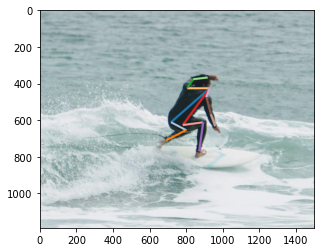

In [12]:
# plot the original image with appendage overlay
draw_stickman(img, json_keypoints)